In [1]:
dfs = {}
preprocessed = {}

In [2]:
import rdata

converted = rdata.read_rda("E:\projects\microagg1d\datasets\Tarragona.rda")
converted["Tarragona"]
dfs["Tarragona"] = converted["Tarragona"]
preprocessed["Tarragona"] = converted["Tarragona"]

In [3]:
converted = rdata.read_rda("E:\projects\microagg1d\datasets\EIA.rda")
converted["EIA"]
dfs["EIA"] = converted["EIA"]
preprocessed["EIA"]=dfs["EIA"][['RESREVENUE', 'RESSALES', 'COMREVENUE', 'COMSALES', 'INDREVENUE', 'INDSALES', 'OTHREVENUE', 'OTHRSALES', 'TOTREVENUE', 'TOTSALES']]

In [4]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [5]:
from microagg1d import univariate_microaggregation
from microagg1d.common import compute_cluster_cost_sorted
from microagg1d.cost import compute_cost
from microagg1d.main import undo_argsort
import numpy as np

In [6]:
def square_sum(x):
    return np.sum(np.square(x))

def absolute_sum(x):
    return np.sum(np.abs(x))

def multi_cost(df_in, clusters, cost_name="sse", preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    average = {
        "sse" : np.mean,
        "sae" : np.median,
    }[cost_name]
    cost_func = {
        "sse" : square_sum,
        "sae" : absolute_sum,
    }[cost_name]
    num_clusters = clusters.max() + 1
    total_cost=0
    for i in range(num_clusters):
        select = clusters == i
        df_select = df[select,:]
        centroid = average(df_select,axis=0)
        total_cost += cost_func(df_select-centroid)
    return total_cost

In [7]:
def do_preprocessing(df_in, preprocess):
    if preprocess:
        return preprocessing.StandardScaler().fit_transform(df_in)
    return df_in

In [8]:
def compute_multi_pca(df_in, k, cost_name="sse", preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    pca = PCA(n_components=1)
    pca.fit(df)
    vec = pca.components_[0,:]
    arr = df @ vec
    order = np.argsort(arr)
    arr = np.array(arr[order], dtype=np.float64)
    clusters = univariate_microaggregation(arr, cost=cost_name, k=k)
    return undo_argsort(clusters, order), vec, order

In [9]:
def compute_multi_random(df_in, k, num_tries=10, cost_name="sse", seed=None, preprocess=True):
    df = do_preprocessing(df_in, preprocess)
    if seed is not None:
        np.random.seed(seed)
    best_clusters= None
    best_vec = None
    best_cost = np.inf
    for i in range(num_tries):
        vec = np.random.rand(df.shape[1])
        arr = df @ vec
        order = np.argsort(arr)
        arr = np.array(arr[order], dtype=np.float64)
        clusters = univariate_microaggregation(arr, cost=cost_name, k=k)
        clusters = undo_argsort(clusters, order)
        cost = multi_cost(df, clusters, cost_name=cost_name, preprocess=False)
        if cost < best_cost:
            best_clusters=clusters
            best_cost=cost
            best_arr = undo_argsort(arr, order)
            best_order = undo_argsort(order, order)
        
    return best_clusters, best_vec, best_order, best_cost

In [10]:
def k_means_heuristic(df_in, k, n_clusters, seed=None, preprocess=True):
    if seed is not None:
        np.random.seed(seed)
    df = do_preprocessing(df_in, preprocess)
    n_clusters = min(n_cluster, len(df))
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed).fit(df)
    all_labels = set(kmeans.labels_)
    labels = kmeans.labels_.copy()
    centroids = kmeans.cluster_centers_.copy()
    changes=False
    while True:
        group_sizes = np.bincount(labels, minlength=len(all_labels)+1)
        labels_to_iter = np.random.permutation(np.fromiter(all_labels, count=len(all_labels), dtype=np.int64))
        if np.all(group_sizes[labels_to_iter] >= k):
            break
        
        
        
        for group_label in labels_to_iter:
            group_size = group_sizes[group_label]
            if group_size < k:
                this_centroid = centroids[group_label]
                min_dist = np.inf
                best_neigh = None
                for i in all_labels:
                    centroid = centroids[i]
                    if i==group_label or group_sizes[i]==0:
                        continue
                    
                    distance = np.sum(np.square(centroid - this_centroid))
                    if distance < min_dist:
                        best_neigh = i
                        min_dist = distance
                centroids[best_neigh] = (centroids[best_neigh]*group_sizes[best_neigh] + 
                                         centroids[group_label]*group_sizes[group_label])/ (
                                        group_sizes[best_neigh] + group_sizes[group_label])
                
                labels[labels==group_label] = best_neigh
                group_sizes[best_neigh] += group_sizes[group_label]
                group_sizes[group_label] = 0
                all_labels.remove(group_label)
                # print("removing", group_label, "to", best_neigh)
                tmp = np.bincount(labels,minlength=len(group_sizes))
                if not np.all(group_sizes == tmp):
                    print(group_sizes)
                    print(tmp)
                    print(group_sizes-tmp)
                    raise ValueError()    
    final_labels = labels.copy()
    
    d = {l:i for i, l in enumerate(all_labels)}
    for i,l in enumerate(labels):
        final_labels[i] = d[l]
    return final_labels

In [11]:
from sklearn.cluster import KMeans

In [12]:
cost_name = "sse"

In [13]:
from collections import defaultdict
results_pca = defaultdict(list)

In [14]:
the_ks = [2,3,4,5,7,10,20,30,40,50]
num_repeats=10
list_num_tries = [10, 50, 100]

In [15]:
results = {}

In [16]:
results["pca"] = defaultdict(list)
for name, df in preprocessed.items():
    df = preprocessing.StandardScaler().fit_transform(df)
    for k in the_ks:
        clusters, arr, order = compute_multi_pca(df, k=k, preprocess=False)
        cost = multi_cost(df, clusters, cost_name=cost_name)

        results["pca"][name].append((k, cost))

In [17]:
from tqdm.notebook import tqdm

In [28]:
num_tries#

10

In [18]:
from microagg1d.multivariate_poly import get_partitions_multivariate_poly, set_both_seeds

In [20]:
set_both_seeds(0)


label = f"poly_{num_tries}"
results[label] = defaultdict(list)
for name, df in preprocessed.items():
    df = preprocessing.StandardScaler().fit_transform(df)
    for k in tqdm(the_ks, leave=False):
        costs = []
        for seed in tqdm(range(num_repeats), leave=False):
            set_both_seeds(seed)
            clusters = get_partitions_multivariate_poly(df, k)
            costs.append(cost)
        results[label][name].append((k, np.mean(costs), np.std(costs)))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
np.random.seed(0)

for num_tries in tqdm(list_num_tries):
    label = f"random_{num_tries}"
    results[label] = defaultdict(list)
    for name, df in preprocessed.items():
        df = preprocessing.StandardScaler().fit_transform(df)
        for k in tqdm(the_ks, leave=False):
            costs = []
            for seed in tqdm(range(num_repeats), leave=False):
                clusters, arr, order, cost = compute_multi_random(df, k=k, num_tries=num_tries, cost_name=cost_name, preprocess=False)
                costs.append(cost)
            results[label][name].append((k, np.mean(costs), np.std(costs)))

In [ ]:
np.random.seed(0)

for factor in tqdm([0.5,1,2], leave=False):
    label = f"merged_{factor}"
    results[label] = defaultdict(list)
    for name, df in preprocessed.items():
        df = preprocessing.StandardScaler().fit_transform(df)
        for k in tqdm(the_ks, leave=False):
            costs = []
            for seed in tqdm(range(num_repeats), leave=False):
                clusters = k_means_heuristic(df, k=k, n_clusters=int(len(df)/k*factor))
                cost = multi_cost(df, clusters, cost_name=cost_name, preprocess=True)
                costs.append(cost)
            results[label][name].append((k, np.mean(costs), np.std(costs)))

In [21]:
for name, df in preprocessed.items():
    print(name, len(df))

Tarragona 834
EIA 4092


In [22]:
import matplotlib.pyplot as plt

In [23]:
import matplotlib
from pathlib import Path

In [24]:
rc_fonts = {
    "font.family": "serif",
    "font.size": 12,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [25]:
def plot_external_legend(original_ax, identifier, figsize=(12, 0.5), fontsize=16):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig, legend_ax = plt.subplots(1, 1,figsize=figsize, sharey=True)
        #fig.set_facecolor("black")
        #fig.pad_inches(0)
        fig.set_tight_layout(True)
        #legend_ax.set_facecolor("black")
        #legend_ax.set_ymargin(-0.1)
        handles, labels = original_ax.get_legend_handles_labels()
        #labels, handles = zip(*sorted(zip(labels, handles)))
        legend_ax.axis('off')
        print(legend_ax.margins())
        #legend_ax.margins(y=0)
        fig.legend(handles, labels, loc='center', mode="expand", ncol=10,  fontsize=fontsize)
        #legend_ax.set_autoscale(enable=True, tight=True)
        fig.savefig(Path(".")/Path('figures')/f'legend_{fontsize}_{identifier}.pdf')

(0.05, 0.05)


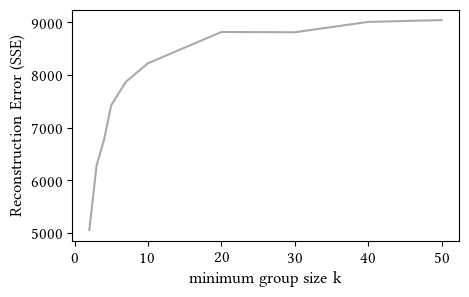

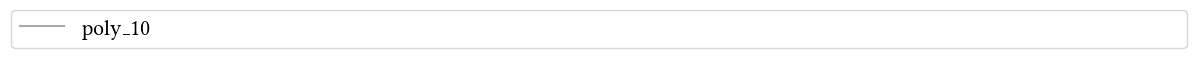

(0.05, 0.05)


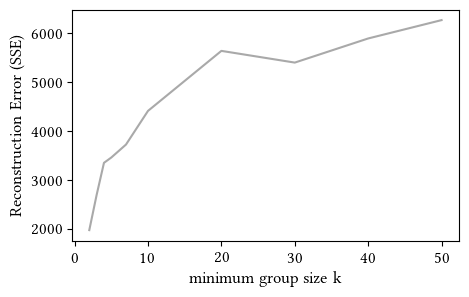

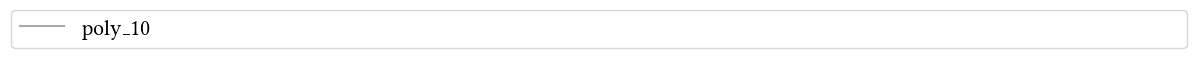

In [34]:
for dataset in ["EIA", "Tarragona"]:
    fig = plt.figure(figsize=(5,3))
    for label, method, color in zip(["poly_10", "PCA", "random_10", "random_50", "random_100", "kmeans_0.5", "kmeans_1", "kmeans_2"],
        ["pca", "random_10", "random_50", "random_100", "merged_0.5", "merged_1", "merged_2"], 
                            ["darkgray", "lightsalmon", "salmon", "red","lightskyblue", "cornflowerblue", "royalblue" ]):
        if method not in results:
            continue
        res = results[method][dataset]
        arr = np.array(res)
        
        # print(arr, method, dataset)
        if arr.shape[1]==3:
            x = arr[:,0]
            y = arr[:,1]
            yerr = arr[:,2]
            plt.errorbar(x, y, yerr=yerr, label=label, color=color)
        else:
            x = arr[:,0]
            y = arr[:,1]
            plt.plot(x,y, label=label, color=color)
    # plt.legend()
    plt.xlabel("minimum group size k")
    plt.ylabel("Reconstruction Error (SSE)")
    # plt.title(dataset)
    
    fig.savefig(Path(".")/'figures'/(dataset+".pdf"), bbox_inches = 'tight', transparent=True)
    # plt.show()
    plot_external_legend(plt.gca(), dataset)
    plt.show()

In [31]:
from datetime import datetime
from pathlib import Path
import pickle
def save_results(prefix, data):
    now = datetime.now()
    
    date_suffix = now.strftime("%Y_%m_%d__%H_%M_%S")
    folder = Path("./results/")
    if not folder.exists():
        raise ValueError(f'Path "{folder.absolute()}" not found')
    out_name = folder/(f"{prefix}_"+date_suffix+".pkl")


    print(out_name)
    with open(out_name, "wb") as f:
        pickle.dump(data, f)

In [ ]:
save_results(".", results)

In [ ]:
print(
    len(dfs["EIA"]),
    len(dfs["EIA"].columns))

In [ ]:
print(
    len(dfs["Tarragona"]),
    len(dfs["Tarragona"].columns))